# Labs Access Analysis: 06 Population Analysis with Facebook Data - No overlaps between isochrones

## Setup

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import os
import gc
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore') # ignore warnings

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
sns.set_context("poster")
sns.set_style(style="whitegrid")
matplotlib.rc('font', family='serif', serif='Fira Sans')

In [3]:
url_data_labs = "data/labs.csv"
url_data_isochrones = "data/isochrones.json"

## Load the data of the labs

load the data with valid coordinates

In [4]:
# Load data, csv
data_csv = pd.read_csv(url_data_labs)
data_csv['Lat'] = data_csv['Lat'].astype(float)
data_csv['Long'] = data_csv['Long'].astype(float)
data_csv = data_csv[(((~data_csv.Lat.isnull()) & (~data_csv.Long.isnull())))]

creation of the geodataframe

In [5]:
data_labs = gpd.GeoDataFrame(
    data_csv,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(data_csv.Long, data_csv.Lat))

show the first 5 rows

In [6]:
data_labs.head(5)

,Name,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,URL 2,geometry
0,3D Incubator,Incubator-Accelerator,Barcelona,BCN,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,NaN,NaN,POINT (2.12304 41.34004)
1,AKASHA Hub Barcelona,Hackerspace,Barcelona,BCN,"carrer de la verneda, 17 loc1",8018.0,41.411054,2.191146,Hackerspaces.org,https://wiki.hackerspaces.org/AKASHA_Hub_Barce...,NaN,NaN,POINT (2.19115 41.41105)
2,Ateneu de Fabricació Ca L'Alier,Ateneu de Fabricació,Barcelona,BCN,"Carrer de Pere IV, 362",8019.0,41.410786,2.203873,Ajuntament.barcelona.cat,NaN,NaN,NaN,POINT (2.20387 41.41079)
3,Ateneu de Fabricació Ciutat Meridiana,Ateneu de Fabricació,Barcelona,BCN,"Av. de Rasos de Peguera, 232",8033.0,41.460460,2.169872,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16987 41.46046)
4,Ateneu de Fabricació Gràcia,Ateneu de Fabricació,Barcelona,BCN,Carrer Perill 8,8012.0,41.399364,2.161167,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16117 41.39936)


In [7]:
#data_labs.set_index('Unnamed: 0', inplace=True)
#data_labs.index.names = ['']

show the data on map

In [8]:
data_labs.explore()

## Analyse the isochrones

load the isochrones

In [9]:
isochrones = pd.read_json(url_data_isochrones)

show the first 5 rows

In [10]:
isochrones.head(5)

,type,bbox,features,metadata,name
0,FeatureCollection,"[2.109858, 41.333106, 2.136626, 41.345904]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,3D Incubator
1,FeatureCollection,"[2.178987, 41.399645, 2.2038, 41.422588]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,AKASHA Hub Barcelona
2,FeatureCollection,"[2.190682, 41.399878, 2.217599, 41.42188]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Ateneu de Fabricació Ca L'Alier
3,FeatureCollection,"[2.162366, 41.45557, 2.182231, 41.467255]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Ateneu de Fabricació Ciutat Meridiana
4,FeatureCollection,"[2.148282, 41.389167, 2.175835, 41.409659]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Ateneu de Fabricació Gràcia


create the geodataframe

In [11]:
isochrones['longitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][0])
isochrones['latitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][1])
isochrones['area_units'] = isochrones['metadata'].apply(lambda x: x['query']['area_units'])

In [12]:
isochrones['total_pop'] = isochrones['features'].apply(lambda x: x[0]['properties']['total_pop'])
isochrones['area'] = isochrones['features'].apply(lambda x:x[0]['properties']['area'])
isochrones['reachfactor'] = isochrones['features'].apply(lambda x: x[0]['properties']['reachfactor'])

In [13]:
isochrones['coordinates'] = isochrones['features'].apply(lambda x: x[0]['geometry']['coordinates'])
isochrones['geometry_type'] = isochrones['features'].apply(lambda x: x[0]['geometry']['type'])

In [14]:
isochrones['geometry'] = isochrones['coordinates'].apply(lambda x: Polygon(x[0]))

In [15]:
isochrones = isochrones[['name','longitude','latitude','total_pop','area','reachfactor','geometry']]

In [16]:
isochrones = gpd.GeoDataFrame(
    isochrones,
    geometry=isochrones.geometry,
    crs='EPSG:4326')

show the isochrones on a map

In [17]:
isochrones.explore()

show the first 5 rows

In [18]:
isochrones.head(5)

,name,longitude,latitude,total_pop,area,reachfactor,geometry
0,3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,"POLYGON ((2.10986 41.33668, 2.11147 41.33429, ..."
1,AKASHA Hub Barcelona,2.191146,41.411054,96774.0,4573263.53,0.9317,"POLYGON ((2.17899 41.41306, 2.17919 41.40872, ..."
2,Ateneu de Fabricació Ca L'Alier,2.203873,41.410786,93219.0,4526884.39,0.9222,"POLYGON ((2.19068 41.40472, 2.19217 41.40230, ..."
3,Ateneu de Fabricació Ciutat Meridiana,2.169872,41.460460,11587.0,1595247.01,0.3250,"POLYGON ((2.16237 41.46718, 2.16239 41.46698, ..."
4,Ateneu de Fabricació Gràcia,2.161167,41.399364,97329.0,4510074.18,0.9188,"POLYGON ((2.14828 41.39726, 2.14829 41.39720, ..."


save as geojson file

In [19]:
isochrones.to_file("data" + os.sep + "lab_isochrones.geojson",driver='GeoJSON')

### merge the attributes of the isochrones with the data of the labs


In [20]:
columns = {
    'name': 'Name'
}
isochrones.rename(columns=columns, inplace=True)

extend the attributes of the isochrones with the data of the labs

In [21]:
labs = isochrones.merge(data_labs, on="Name")
labs = gpd.GeoDataFrame(labs)

In [22]:
columns = {
    'geometry_x': 'geometry'
}
labs.rename(columns=columns, inplace=True)

read the first 5 row

In [23]:
labs.head(5)

,Name,longitude,latitude,total_pop,area,reachfactor,geometry,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,URL 2,geometry_y
0,3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,"POLYGON ((2.10986 41.33668, 2.11147 41.33429, ...",Incubator-Accelerator,Barcelona,BCN,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,NaN,NaN,POINT (2.12304 41.34004)
1,AKASHA Hub Barcelona,2.191146,41.411054,96774.0,4573263.53,0.9317,"POLYGON ((2.17899 41.41306, 2.17919 41.40872, ...",Hackerspace,Barcelona,BCN,"carrer de la verneda, 17 loc1",8018.0,41.411054,2.191146,Hackerspaces.org,https://wiki.hackerspaces.org/AKASHA_Hub_Barce...,NaN,NaN,POINT (2.19115 41.41105)
2,Ateneu de Fabricació Ca L'Alier,2.203873,41.410786,93219.0,4526884.39,0.9222,"POLYGON ((2.19068 41.40472, 2.19217 41.40230, ...",Ateneu de Fabricació,Barcelona,BCN,"Carrer de Pere IV, 362",8019.0,41.410786,2.203873,Ajuntament.barcelona.cat,NaN,NaN,NaN,POINT (2.20387 41.41079)
3,Ateneu de Fabricació Ciutat Meridiana,2.169872,41.460460,11587.0,1595247.01,0.3250,"POLYGON ((2.16237 41.46718, 2.16239 41.46698, ...",Ateneu de Fabricació,Barcelona,BCN,"Av. de Rasos de Peguera, 232",8033.0,41.460460,2.169872,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16987 41.46046)
4,Ateneu de Fabricació Gràcia,2.161167,41.399364,97329.0,4510074.18,0.9188,"POLYGON ((2.14828 41.39726, 2.14829 41.39720, ...",Ateneu de Fabricació,Barcelona,BCN,Carrer Perill 8,8012.0,41.399364,2.161167,Ajuntament.barcelona.cat,https://ajuntament.barcelona.cat/ateneusdefabr...,NaN,NaN,POINT (2.16117 41.39936)


In [24]:
columns = {
    'Name': 'name',
    'Type': 'type',
    'City': 'city',
    'Cluster':  'cluster',
    'Address': 'address',
    'CAP': 'zipcode',
    'Source': 'source',
    'URL': 'url',
    'Notes': 'notes',
    'geomtry_y': 'geomtry'
}
labs.rename(columns=columns, inplace=True)

In [25]:
#labs.to_file("data/labs_isochrones.geojson",driver='GeoJSON')

## Analysis of Facebook data

### Setup and functions

In [26]:
labs_ita = labs[labs.cluster == "MI"]
labs_esp = labs[labs.cluster == "BCN"]
labs_ita = gpd.GeoDataFrame(labs_ita)
labs_esp = gpd.GeoDataFrame(labs_esp)

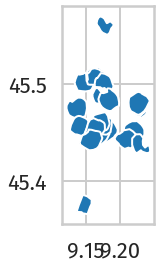

In [27]:
labs_ita.plot()
plt.show()

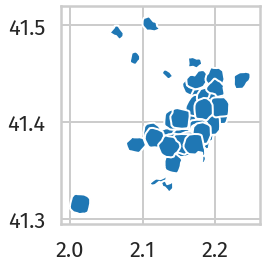

In [28]:
labs_esp.plot()
plt.show()

In [29]:
area_total_ita = labs[labs.cluster == "MI"].dissolve(by='cluster').set_crs(epsg=4326, inplace=True)
area_total_esp = labs[labs.cluster == "BCN"].dissolve(by='cluster').set_crs(epsg=4326, inplace=True)

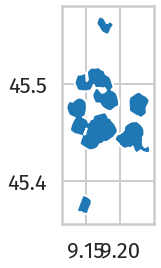

In [30]:
area_total_ita.plot()
plt.show()

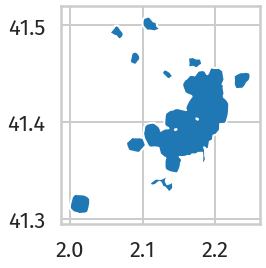

In [31]:
area_total_esp.plot()
plt.show()

In [32]:
area_total_esp

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,zipcode,Lat,Long,source,url,notes,URL 2,geometry_y
cluster,,,,,,,,,,,,,,,,,,
BCN,"MULTIPOLYGON (((2.00585 41.32525, 2.00596 41.3...",3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,Incubator-Accelerator,Barcelona,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,None,https://bcnsostenible.cat/web/punt/espai-dinte...,POINT (2.12304 41.34004)


functions needed for the analysis

In [33]:
def getgeodataframearea(points,x,y):
    global isochrones
    env = env = isochrones.envelope.unary_union.bounds
    area = points[(points[x] >= env[0]) & (points[x] <= env[2]) & (points[y] >= env[1]) & (points[y] <= env[3])]
    geodataframe = gpd.GeoDataFrame(
        points,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(points[x], points[y]))
    return geodataframe

In [34]:
def adddatafromfile(data, file, column, datacolumn, coordcolname, tab):
    if tab:
        new_data = pd.read_csv(file, sep='\t')
    else:
        new_data = pd.read_csv(file)
    if coordcolname == "LatLon":
        new_data.rename({'Lon': 'longitude', 'Lat': 'latitude', 'Population': 'population'}, axis=1, inplace=True)
    else:
        new_data.rename({datacolumn: 'population'}, axis=1, inplace=True)
    points_cluster = getgeodataframearea(new_data,x='longitude',y='latitude')
    # save memory - destroy dataframe unused
    # del [[isochrones,ita_population,ita_15_24]]
    del [[new_data]]
    gc.collect()
    isochrones=pd.DataFrame()
    new_data=pd.DataFrame()
    sjoin_lab_points = points_cluster.sjoin(data, how='inner')
    data[column] = data.city.apply(lambda x: round(sjoin_lab_points[sjoin_lab_points.city == x].population.sum()))
    return

### add for Italy

In [35]:
prefix = "data" + os.sep + "hdx" + os.sep
adddatafromfile(data=area_total_ita, file = prefix + "population_ita_2019-07-01.csv", column='total', datacolumn="Population", coordcolname="LatLon", tab=False)

In [36]:
adddatafromfile(data=area_total_ita, file = prefix + "ITA_men_2019-08-03.csv", column='men', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

In [37]:
adddatafromfile(data=area_total_ita, file = prefix + "ITA_women_2019-08-03.csv", column='women', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

### add data for Spain

In [38]:
adddatafromfile(data=area_total_esp, file = prefix + "esp_general_2020.csv", column='total', datacolumn="esp_general_2020", coordcolname="LatitudeLongitude", tab=False)

In [39]:
adddatafromfile(data=area_total_esp, file = prefix + "esp_men_2020.csv", column='men', datacolumn="esp_men_2020", coordcolname="LatitudeLongitude", tab=False)

In [40]:
adddatafromfile(data=area_total_esp, file = prefix + "esp_women_2020.csv", column='women', datacolumn="esp_women_2020", coordcolname="LatitudeLongitude", tab=False)

In [41]:
area_total_ita

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,...,Lat,Long,source,url,notes,URL 2,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,,
MI,"MULTIPOLYGON (((9.17258 45.43778, 9.17032 45.4...",DamASpace,9.179818,45.452457,59746.0,4910677.26,1.0,Fab Lab,Milan,"Corso S. Gottardo, 19",...,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,City Manufacturing network,None,POINT (9.17982 45.45246),559041,241857,262146


In [42]:
area_total_esp

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,...,Lat,Long,source,url,notes,URL 2,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,,
BCN,"MULTIPOLYGON (((2.00585 41.32525, 2.00596 41.3...",3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,Incubator-Accelerator,Barcelona,"Polígono Industrial de la, Avinguda Parc Logís...",...,41.340036,2.123036,Manually added,https://www.incubator3d.org/,None,https://bcnsostenible.cat/web/punt/espai-dinte...,POINT (2.12304 41.34004),1388928,662331,726597


total of area for men and women covered from the cluster of Milan

In [43]:
area_total_ita[["total", "men", "women"]]

,total,men,women
cluster,,,
MI,559041,241857,262146


total of area for men and women covered from the cluster of Barcelona

In [44]:
area_total_esp[["total", "men", "women"]]

,total,men,women
cluster,,,
BCN,1388928,662331,726597


unione of the data

In [45]:
area_total_both = pd.concat([area_total_ita, area_total_esp])

In [46]:
area_total_both

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,...,Lat,Long,source,url,notes,URL 2,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,,
MI,"MULTIPOLYGON (((9.17258 45.43778, 9.17032 45.4...",DamASpace,9.179818,45.452457,59746.0,4910677.26,1.0000,Fab Lab,Milan,"Corso S. Gottardo, 19",...,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,City Manufacturing network,None,POINT (9.17982 45.45246),559041,241857,262146
BCN,"MULTIPOLYGON (((2.00585 41.32525, 2.00596 41.3...",3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,Incubator-Accelerator,Barcelona,"Polígono Industrial de la, Avinguda Parc Logís...",...,41.340036,2.123036,Manually added,https://www.incubator3d.org/,None,https://bcnsostenible.cat/web/punt/espai-dinte...,POINT (2.12304 41.34004),1388928,662331,726597


### Plot the data

population reached

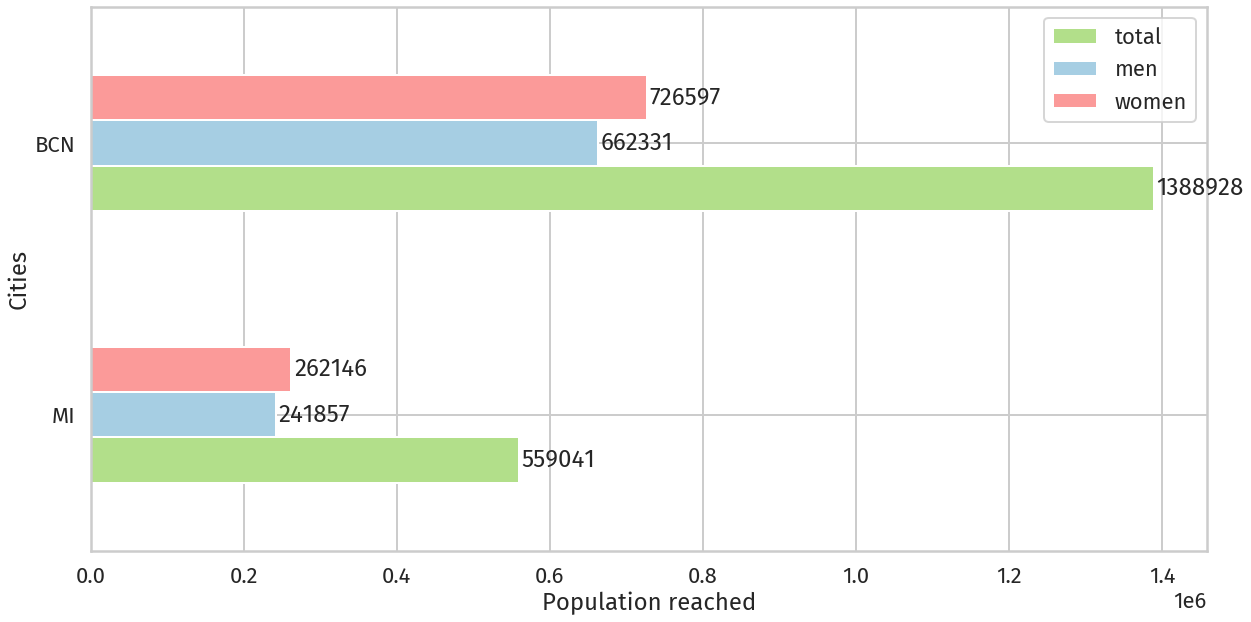

In [47]:
colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
ax = area_total_both[["total", "men", "women"]].plot(kind="barh", color=colors, figsize=(20,10))
ax.bar_label(ax.containers[0], fmt="%d", size=24, padding=3)
ax.bar_label(ax.containers[1], fmt="%d", size=24, padding=3)
ax.bar_label(ax.containers[2], fmt="%d", size=24, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Cities')
plt.savefig("svg" + os.sep + "labs_esp_ita_fbpop_tot.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "labs_esp_ita_fbpop_tot.png", dpi=300, bbox_inches="tight")

### area

In [48]:
area_total_both["area"]

cluster
MI     4910677.26
BCN    1257375.85
Name: area, dtype: float64

In [49]:
area_total_both.set_crs(epsg=4326, inplace=True)

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,...,Lat,Long,source,url,notes,URL 2,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,,
MI,"MULTIPOLYGON (((9.17258 45.43778, 9.17032 45.4...",DamASpace,9.179818,45.452457,59746.0,4910677.26,1.0000,Fab Lab,Milan,"Corso S. Gottardo, 19",...,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,City Manufacturing network,None,POINT (9.17982 45.45246),559041,241857,262146
BCN,"MULTIPOLYGON (((2.00585 41.32525, 2.00596 41.3...",3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,Incubator-Accelerator,Barcelona,"Polígono Industrial de la, Avinguda Parc Logís...",...,41.340036,2.123036,Manually added,https://www.incubator3d.org/,None,https://bcnsostenible.cat/web/punt/espai-dinte...,POINT (2.12304 41.34004),1388928,662331,726597


show the areas on the map

In [50]:
area_total_both.explore()

In [51]:
area_total_both.to_crs(epsg=3857).geometry.area

cluster
MI     1.045575e+08
BCN    1.455153e+08
dtype: float64

area in square kilometers

In [52]:
area_total_square_km = area_total_both.to_crs(epsg=3857).geometry.area / 1000000.0

In [53]:
area_total_square_km

cluster
MI     104.557520
BCN    145.515262
dtype: float64

Plot the data

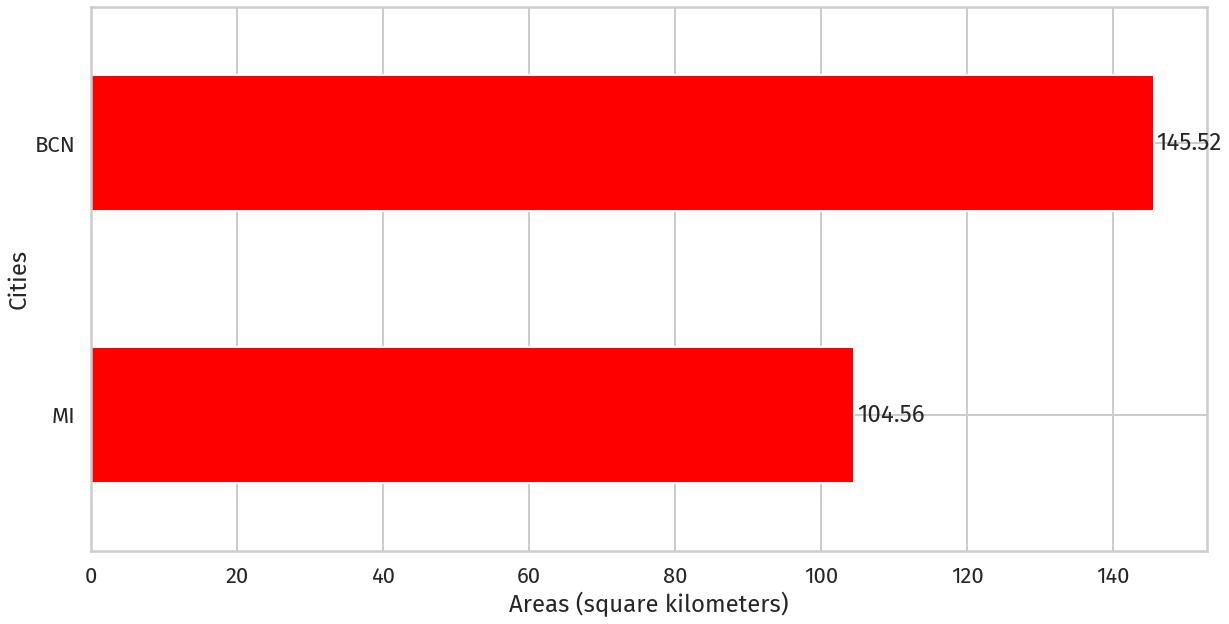

In [54]:
ax = area_total_square_km.plot(kind="barh", figsize=(20,10), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=24, padding=3)
plt.xlabel('Areas (square kilometers)')
plt.ylabel('Cities')
plt.savefig("svg" + os.sep + "labs_esp_ita_area_tot.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "labs_esp_ita_area_tot.png", dpi=300, bbox_inches="tight")

### Intersections / Overlaps

#### Italy

In [55]:
labs_ita_intersections = gpd.overlay(labs_ita, labs_ita, how="intersection")

In [56]:
print("The number of labs in Italy is %d" % labs_ita.shape[0])

The number of labs in Italy is 24


show the first 5 rows

In [57]:
labs_ita_intersections.head(5)

,name_1,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,...,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,URL 2_2,geometry_y_2,geometry
0,DamASpace,9.179818,45.452457,59746.0,4910677.26,1.0000,Fab Lab,Milan,MI,"Corso S. Gottardo, 19",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.16413 45.45124, 9.16560 45.45683, ..."
1,Miocugino - officina di gesta e ingegno,9.168956,45.448219,40702.0,3844697.17,0.7832,Makerspace,Milan,MI,via argelati 35,...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.16590 45.45665, 9.16690 45.45818, ..."
2,SuperForma Lab,9.173072,45.457594,57463.0,4535136.81,0.9239,Service,Milan,MI,"Via Fabio Mangone, 1/A,",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.18769 45.45710, 9.18751 45.45659, ..."
3,TinkeringZone Maker space,9.171362,45.461679,44822.0,3448109.56,0.7024,Museum Lab,Milan,MI,"Via S. Vittore, 21",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.18347 45.46279, 9.18459 45.45974, ..."
4,Rete Nema,9.164229,45.452670,49400.0,3521936.11,0.7175,City Manufacturing Network Hub,Milan,MI,"Via Bergognone, 34",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.17175 45.46201, 9.17522 45.46050, ..."


show the data on the map

In [58]:
labs_ita_intersections.explore()

Overlapping areas is where name_1 and name_2 column are different, indicating which labs overlaps

In [59]:
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"]

,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,zipcode_1,...,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,URL 2_2,geometry_y_2,geometry
name_1,,,,,,,,,,,,,,,,,,,,,
The FabLab: Make in Milano,9.207913,45.444046,41302.0,3877922.8,0.79,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,...,"Via Tertulliano, 70",20137.0,45.450348,9.220968,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/opendot,NaN,NaN,POINT (9.22097 45.45035),"POLYGON ((9.20600 45.45221, 9.21086 45.45290, ..."
The FabLab: Make in Milano,9.207913,45.444046,41302.0,3877922.8,0.79,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,...,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,"Fablabs.io, Comune.milano.it",https://www.thefablab.it/,NaN,NaN,POINT (9.20791 45.44405),"POLYGON ((9.19176 45.44332, 9.19281 45.44492, ..."
The FabLab: Make in Milano,9.207913,45.444046,41302.0,3877922.8,0.79,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,...,"Via Carlo Boncompagni, 57",20139.0,45.438305,9.231811,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/vectorealismfablab,NaN,NaN,POINT (9.23181 45.43830),"POLYGON ((9.22311 45.44794, 9.22393 45.44600, ..."


the areas of one lab..


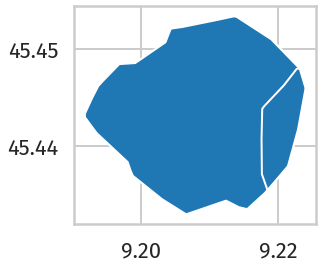

In [60]:
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].plot()
plt.show()

Overall area

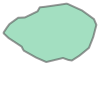

In [61]:
labs_ita.set_index("name").loc["The FabLab: Make in Milano"].geometry

area 0

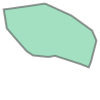

In [62]:
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].iloc[0].geometry

area 1

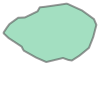

In [63]:
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].iloc[1].geometry

area 2

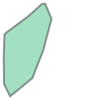

In [64]:
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].iloc[2].geometry

Create a dataframe with overlapping areas

In [65]:
overlapping_areas_ita = labs_ita_intersections.loc[~(labs_ita_intersections['name_1'] == labs_ita_intersections['name_2'])]

show the data

In [66]:
overlapping_areas_ita

,name_1,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,...,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,URL 2_2,geometry_y_2,geometry
1,Miocugino - officina di gesta e ingegno,9.168956,45.448219,40702.0,3844697.17,0.7832,Makerspace,Milan,MI,via argelati 35,...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.16590 45.45665, 9.16690 45.45818, ..."
2,SuperForma Lab,9.173072,45.457594,57463.0,4535136.81,0.9239,Service,Milan,MI,"Via Fabio Mangone, 1/A,",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.18769 45.45710, 9.18751 45.45659, ..."
3,TinkeringZone Maker space,9.171362,45.461679,44822.0,3448109.56,0.7024,Museum Lab,Milan,MI,"Via S. Vittore, 21",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.18347 45.46279, 9.18459 45.45974, ..."
4,Rete Nema,9.164229,45.452670,49400.0,3521936.11,0.7175,City Manufacturing Network Hub,Milan,MI,"Via Bergognone, 34",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.17175 45.46201, 9.17522 45.46050, ..."
5,Repair Cafè Lab Barona,9.157498,45.442659,31641.0,4306361.89,0.8773,Repair Cafè,Milan,MI,"Via Ettore Ponti, 15",...,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,"Fablabs.io, Comune.milano.it",https://fablabs.io/labs/DamASpaceFablab,NaN,NaN,POINT (9.17982 45.45246),"POLYGON ((9.16524 45.45148, 9.16788 45.45116, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,MaBa.SAPERLab Politecnico di Milano,9.227141,45.479739,69917.0,4428197.22,0.9021,University Lab,Milan,MI,"Via Ampère 2, Campus Bonardi, building 11, bas...",...,Via Giovanni Celoria 7,20133.0,45.477347,9.230418,Hackerspaces.org,https://wiki.hackerspaces.org/Politecnico_Open...,NaN,NaN,POINT (9.23042 45.47735),"POLYGON ((9.23524 45.47179, 9.23034 45.46904, ..."
93,Politecnico Open unix Labs,9.230418,45.477347,63587.0,3952195.24,0.8051,Hackerspace,Milan,MI,Via Giovanni Celoria 7,...,"Piazza Leonardo da Vinci, 32",20133.0,45.477832,9.227890,Manually added,https://piulab.it/,NaN,NaN,POINT (9.22789 45.47783),"POLYGON ((9.22151 45.46914, 9.21640 45.47146, ..."
95,MaBa.SAPERLab Politecnico di Milano,9.227141,45.479739,69917.0,4428197.22,0.9021,University Lab,Milan,MI,"Via Ampère 2, Campus Bonardi, building 11, bas...",...,"Piazza Leonardo da Vinci, 32",20133.0,45.477832,9.227890,Manually added,https://piulab.it/,NaN,NaN,POINT (9.22789 45.47783),"POLYGON ((9.23856 45.47530, 9.23838 45.47505, ..."
96,Politecnico Open unix Labs,9.230418,45.477347,63587.0,3952195.24,0.8051,Hackerspace,Milan,MI,Via Giovanni Celoria 7,...,"Via Ampère 2, Campus Bonardi, building 11, bas...",20133.0,45.479739,9.227141,Manually added,https://www.dabc.polimi.it/en/abclab/le-unita/...,NaN,NaN,POINT (9.22714 45.47974),"POLYGON ((9.21640 45.47146, 9.21536 45.47225, ..."


show the data on a map

In [67]:
overlapping_areas_ita.explore()

Compare the areas on the map

In [68]:
labs_ita.set_crs(epsg=4326).explore()

area of all areas

In [69]:
overlapping_areas_ita.to_crs(epsg=3857).geometry.area

1     4.582662e+06
2     5.695520e+06
3     3.446005e+06
4     2.686259e+06
5     8.567341e+05
          ...     
92    7.029606e+06
93    7.081007e+06
95    7.551516e+06
96    7.029606e+06
97    7.551516e+06
Length: 76, dtype: float64

cumulative overlaps = individual areas served by more than 1 lab, with overlaps

In [70]:

overlapping_areas_ita.to_crs(epsg=3857).geometry.area.sum() / 1000000

229.57946296890628

union of overlaps = overall area that is served by more than 1 lab, union with no overlaps


In [71]:
overlapping_areas_ita.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000

41.751706642092536

percentage of overlap


In [72]:
overlap_total_area_ita = overlapping_areas_ita.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000
total_area_ita = area_total_both.to_crs(epsg=3857).loc["MI"].geometry.area / 1000000
percentage_ita = overlap_total_area_ita / total_area_ita * 100
print(percentage_ita,"%")

39.93180669753172 %


### Spain

In [73]:
labs_esp_intersections = gpd.overlay(labs_esp, labs_esp, how="intersection")

number of lab areas in Spain

In [74]:
print("the number of the labs in the area is %s" % str(labs_esp.shape[0]))

the number of the labs in the area is 53


In [75]:
print("the number of overlapping areas in Spain is %s" % str(labs_esp_intersections.shape[0]))

the number of overlapping areas in Spain is 491


show the first 5 rows

In [76]:
labs_esp_intersections.head(5)

,name_1,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,...,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,URL 2_2,geometry_y_2,geometry
0,3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,Incubator-Accelerator,Barcelona,BCN,"Polígono Industrial de la, Avinguda Parc Logís...",...,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,NaN,NaN,POINT (2.12304 41.34004),"POLYGON ((2.10986 41.33668, 2.11010 41.33695, ..."
1,IAM3DHUB / Dfactory Barcelona,2.138019,41.336487,28808.0,1150407.81,0.2344,Incubator-Accelerator,Barcelona,BCN,"Carrer 27, 10-16 Sector BZ Zona Franca",...,"Polígono Industrial de la, Avinguda Parc Logís...",8040.0,41.340036,2.123036,Manually added,https://www.incubator3d.org/,NaN,NaN,POINT (2.12304 41.34004),"POLYGON ((2.12551 41.33735, 2.12563 41.33769, ..."
2,3D Incubator,2.123036,41.340036,25847.0,1257375.85,0.2562,Incubator-Accelerator,Barcelona,BCN,"Polígono Industrial de la, Avinguda Parc Logís...",...,"Carrer 27, 10-16 Sector BZ Zona Franca",8040.0,41.336487,2.138019,Manually added,https://www.dfactorybcn.org/,NaN,NaN,POINT (2.13802 41.33649),"POLYGON ((2.13175 41.33829, 2.13282 41.33615, ..."
3,IAM3DHUB / Dfactory Barcelona,2.138019,41.336487,28808.0,1150407.81,0.2344,Incubator-Accelerator,Barcelona,BCN,"Carrer 27, 10-16 Sector BZ Zona Franca",...,"Carrer 27, 10-16 Sector BZ Zona Franca",8040.0,41.336487,2.138019,Manually added,https://www.dfactorybcn.org/,NaN,NaN,POINT (2.13802 41.33649),"POLYGON ((2.12551 41.33735, 2.12563 41.33769, ..."
4,AKASHA Hub Barcelona,2.191146,41.411054,96774.0,4573263.53,0.9317,Hackerspace,Barcelona,BCN,"carrer de la verneda, 17 loc1",...,"carrer de la verneda, 17 loc1",8018.0,41.411054,2.191146,Hackerspaces.org,https://wiki.hackerspaces.org/AKASHA_Hub_Barce...,NaN,NaN,POINT (2.19115 41.41105),"POLYGON ((2.17899 41.41306, 2.17917 41.41367, ..."


the areas of one lab


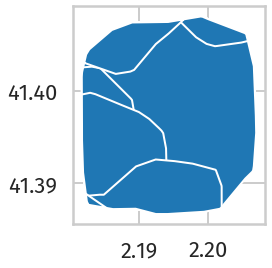

In [77]:
labs_esp_intersections.set_index("name_1").loc["Fab Lab Barcelona"].plot()
plt.show()

create a dataframe with overlapping areas

In [78]:
overlapping_areas_esp = labs_esp_intersections.loc[~(labs_esp_intersections['name_1'] == labs_esp_intersections['name_2'])]

show the data on the map

In [79]:
overlapping_areas_esp.explore()

In [80]:
labs_esp_intersections.explore()

compare with areas

In [81]:
labs_esp.set_crs(epsg=4326).explore()

area of all areas.. 


In [82]:
overlapping_areas_esp.to_crs(epsg=3857).geometry.area

1      5.199148e+05
2      5.199148e+05
5      3.622796e+06
6      3.576443e+06
7      4.129077e+06
           ...     
482    7.261682e+05
483    9.906181e+05
484    8.624852e+04
485    1.435875e+05
487    6.353912e+05
Length: 438, dtype: float64

cumulative overlaps = individual areas served by more than 1 lab, with overlaps

In [83]:
overlapping_areas_esp.to_crs(epsg=3857).geometry.area.sum() / 1000000

941.7302369230198

union of overlaps = overall area that is served by more than 1 lab, union with no overlaps


In [84]:
overlapping_areas_esp.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000

81.94197817719424

Percentage of overlap:


In [85]:
overlap_total_area_esp = overlapping_areas_esp.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000
total_area_esp = area_total_both.to_crs(epsg=3857).loc["BCN"].geometry.area / 1000000
percentage_esp = overlap_total_area_esp / total_area_esp * 100
print(percentage_esp,"%")

56.31160418357987 %


data for plotting


In [86]:
areas_plot = pd.DataFrame(columns = ["City", "Total area reached", "Overlapping area"])

In [87]:
areas_plot = areas_plot.append({'City':'BCN', 'Total area reached':total_area_esp, 'Overlapping area': overlap_total_area_esp}, ignore_index=True)

In [88]:
areas_plot = areas_plot.append({'City':'MI', 'Total area reached':total_area_ita, 'Overlapping area': overlap_total_area_ita}, ignore_index=True)

In [89]:
areas_plot.set_index("City", inplace=True)

plot the data

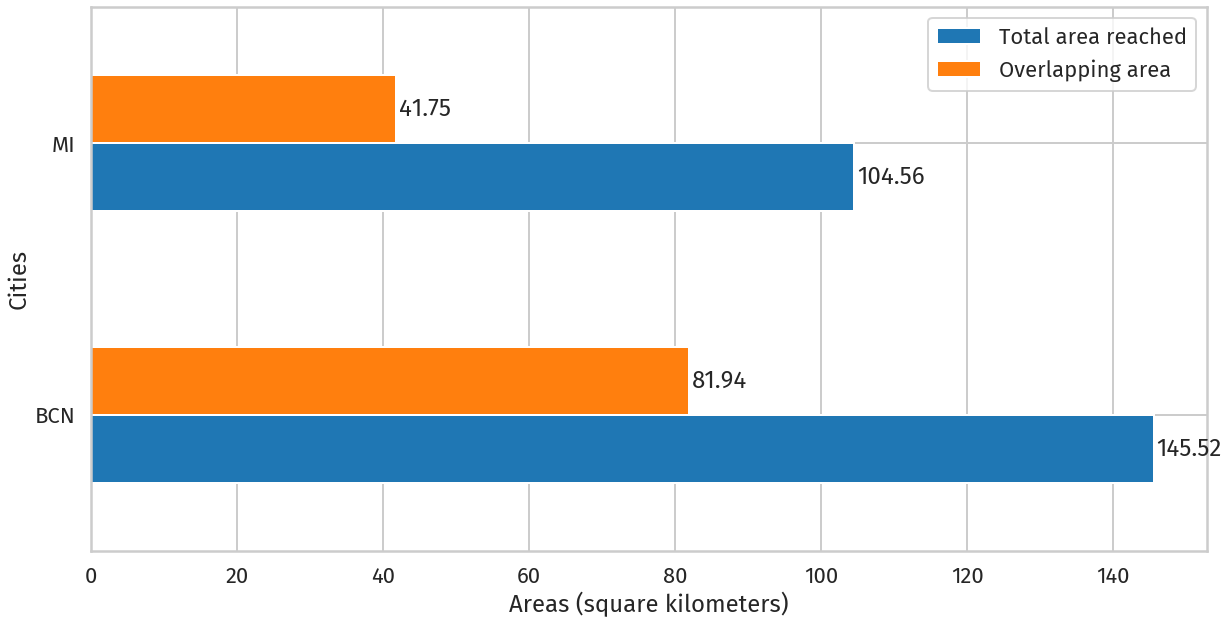

In [90]:
ax = areas_plot.plot(kind="barh", figsize=(20,10))
ax.bar_label(ax.containers[0], fmt="%.2f", size=24, padding=3)
ax.bar_label(ax.containers[1], fmt="%.2f", size=24, padding=3)
plt.xlabel('Areas (square kilometers)')
plt.ylabel('Cities')
plt.savefig("svg" + os.sep + "labs_esp_ita_area_tot_overlaps.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "labs_esp_ita_area_tot_overlaps.png", dpi=300, bbox_inches="tight")

two plots together


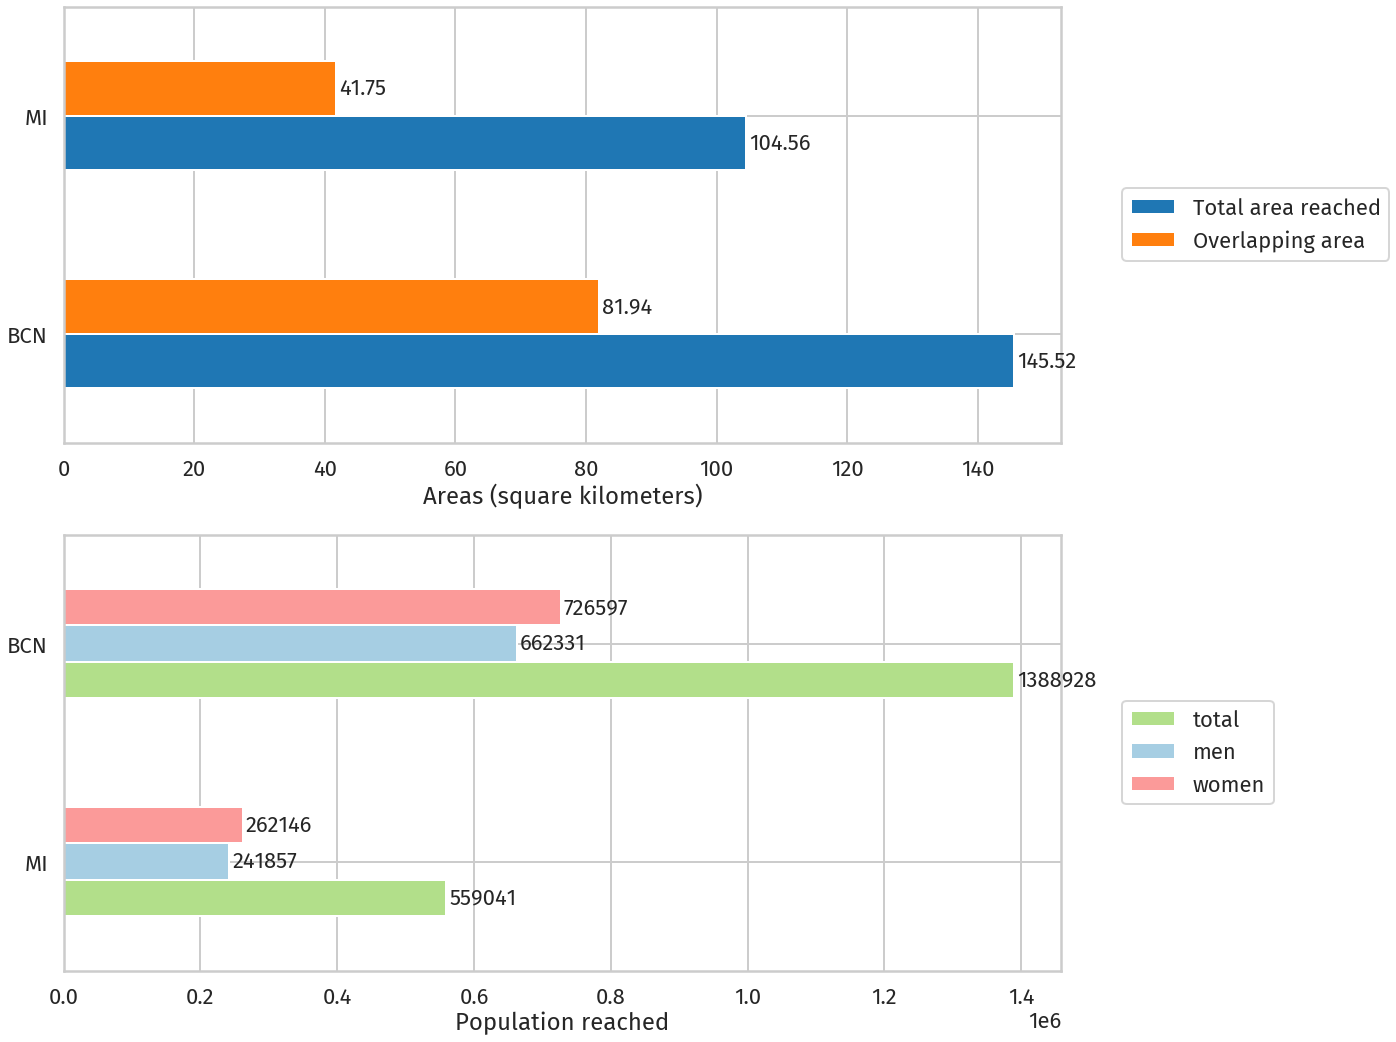

In [91]:
figure, axes = plt.subplots(2, 1, figsize=(20,15))
areas_plot.plot(ax=axes[0], kind="barh")
axes[0].bar_label(axes[0].containers[0], fmt="%.2f", size=22, padding=3)
axes[0].bar_label(axes[0].containers[1], fmt="%.2f", size=22, padding=3)
axes[0].set_xlabel('Areas (square kilometers)')
axes[0].set_ylabel('')

colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
area_total_both[["total", "men", "women"]].plot(ax=axes[1], kind="barh", color=colors)
axes[1].bar_label(axes[1].containers[0], fmt="%d", size=22, padding=3)
axes[1].bar_label(axes[1].containers[1], fmt="%d", size=22, padding=3)
axes[1].bar_label(axes[1].containers[2], fmt="%d", size=22, padding=3)
axes[1].set_xlabel('Population reached')
axes[1].set_ylabel('')

axes[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))


#axes[0].title.set_text('Area')
#axes[1].title.set_text('Population')

plt.tight_layout()
plt.savefig("png" + os.sep + "labs_esp_ita_area_pop_subplot.png", dpi=300, bbox_inches='tight')
plt.savefig("svg" + os.sep + "labs_esp_ita_area_pop_subplot.svg", bbox_inches='tight')